<a href="https://colab.research.google.com/github/Aniket2074/COVID-19_Data_Analysis/blob/main/COVID_19_Data_Analysis_InlighnX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import io, os
sns.set_style("whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

In [16]:
#Load the dataset : Johns Hopkins COVID-19 Dataset
CONF_URL = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
            "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
DEATHS_URL = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
              "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
RECOV_URL = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
            "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

df_conf = pd.read_csv(CONF_URL)
df_deaths = pd.read_csv(DEATHS_URL)

# recovered file may not always be present or useful, so try to read but handle failure gracefully
try:
    df_recov = pd.read_csv(RECOV_URL)
except Exception as e:
    df_recov = None
    print("Recovered data not loaded (may be absent or deprecated). Continuing without recovered.")

print("Confirmed rows:", df_conf.shape)
print("Deaths rows:", df_deaths.shape, "Recovered loaded:", df_recov is not None)


Confirmed rows: (289, 1147)
Deaths rows: (289, 1147) Recovered loaded: True


In [17]:
# helper to melt and aggregate by country
def melt_jhu(df, value_name):
    # Columns are: Province/State, Country/Region, Lat, Long, then many date columns like 1/22/20
    id_vars = ['Province/State','Country/Region','Lat','Long']
    # Some files may not have 'Province/State' column name exactly; check:
    for c in id_vars:
        if c not in df.columns:
            # try alternative names
            pass
    dfm = df.melt(id_vars=['Province/State','Country/Region','Lat','Long'],
                  var_name='Date', value_name=value_name)
    dfm['Date'] = pd.to_datetime(dfm['Date'])
    # aggregate at country level (sum provinces)
    dfc = dfm.groupby(['Country/Region','Date'], as_index=False)[value_name].sum()
    return dfc

conf_long = melt_jhu(df_conf, 'Confirmed')
deaths_long = melt_jhu(df_deaths, 'Deaths')
if df_recov is not None:
    recov_long = melt_jhu(df_recov, 'Recovered')
else:
    recov_long = None

print("Conf long example:\n", conf_long.head())


/tmp/ipython-input-1857045923.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfm['Date'] = pd.to_datetime(dfm['Date'])
/tmp/ipython-input-1857045923.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfm['Date'] = pd.to_datetime(dfm['Date'])


Conf long example:
   Country/Region       Date  Confirmed
0    Afghanistan 2020-01-22          0
1    Afghanistan 2020-01-23          0
2    Afghanistan 2020-01-24          0
3    Afghanistan 2020-01-25          0
4    Afghanistan 2020-01-26          0


/tmp/ipython-input-1857045923.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfm['Date'] = pd.to_datetime(dfm['Date'])


In [18]:
# compute daily new cases and 7-day rolling averages
# World totals
world = conf_long.groupby('Date', as_index=False)['Confirmed'].sum().sort_values('Date')
world['New_Cases'] = world['Confirmed'].diff().fillna(0)
world['New_Cases'] = world['New_Cases'].clip(lower=0)   # clip negative corrections to 0 for visualization
world['MA7_NewCases'] = world['New_Cases'].rolling(7, min_periods=1).mean()

# By country: add New_Cases and MA7 per country
conf_long = conf_long.sort_values(['Country/Region','Date'])
conf_long['New_Cases'] = conf_long.groupby('Country/Region')['Confirmed'].diff().fillna(0)
conf_long['New_Cases'] = conf_long['New_Cases'].clip(lower=0)
conf_long['MA7_NewCases'] = conf_long.groupby('Country/Region')['New_Cases']\
                                    .rolling(7, min_periods=1).mean()\
                                    .reset_index(level=0, drop=True)

print("World sample:\n", world.tail())
print("Country sample:\n", conf_long[conf_long['Country/Region']=='India'].tail())


World sample:
            Date  Confirmed  New_Cases   MA7_NewCases
1138 2023-03-05  676024901    56126.0  140069.571429
1139 2023-03-06  676082941    58040.0  130214.571429
1140 2023-03-07  676213378   130437.0  127305.714286
1141 2023-03-08  676392824   179446.0  121424.571429
1142 2023-03-09  676570149   177325.0  119748.285714
Country sample:
       Country/Region       Date  Confirmed  New_Cases  MA7_NewCases
92578          India 2023-03-05   44689327      281.0    271.285714
92579          India 2023-03-06   44689593      266.0    285.142857
92580          India 2023-03-07   44689919      326.0    297.428571
92581          India 2023-03-08   44690298      379.0    313.285714
92582          India 2023-03-09   44690738      440.0    335.714286


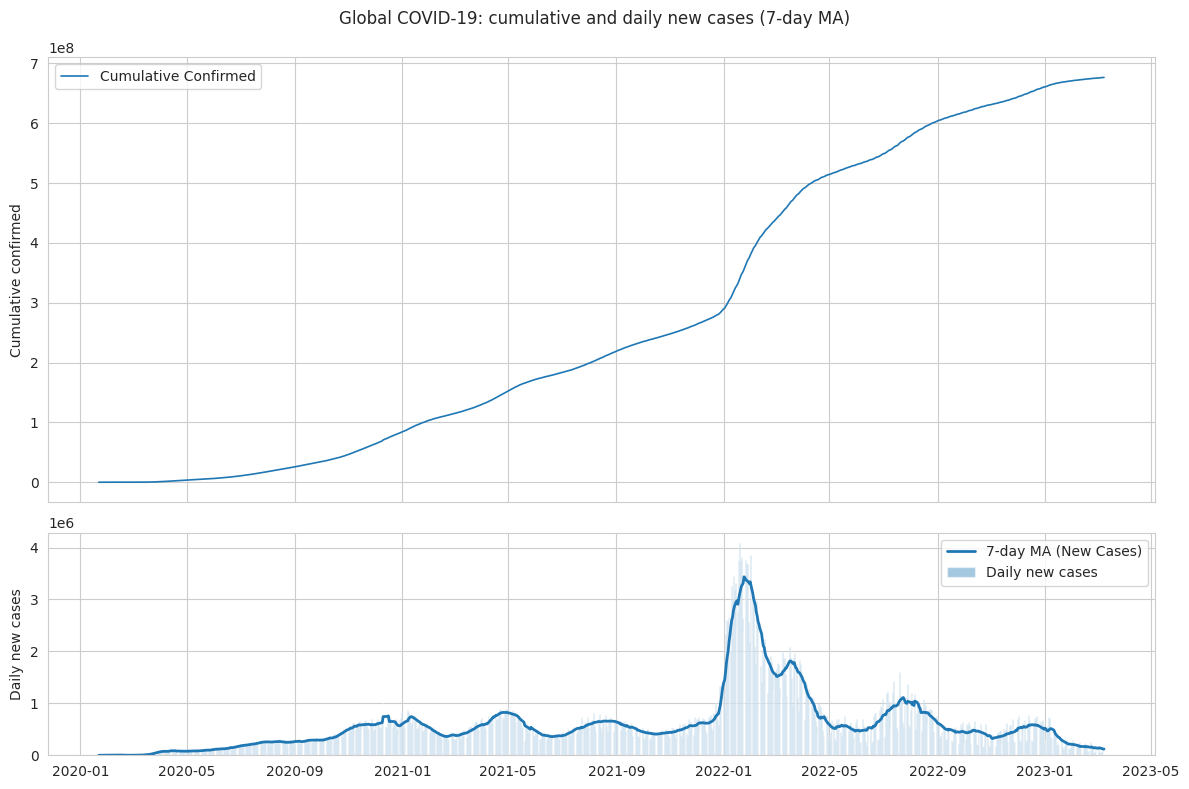

In [19]:
# global timeline plot
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True, gridspec_kw={'height_ratios':[2,1]})
ax[0].plot(world['Date'], world['Confirmed'], lw=1.2, label='Cumulative Confirmed')
ax[0].set_ylabel("Cumulative confirmed")
ax[0].legend()
ax[1].bar(world['Date'], world['New_Cases'], alpha=0.4, label='Daily new cases')
ax[1].plot(world['Date'], world['MA7_NewCases'], lw=2, label='7-day MA (New Cases)')
ax[1].set_ylabel("Daily new cases")
ax[1].legend()
plt.suptitle("Global COVID-19: cumulative and daily new cases (7-day MA)")
plt.tight_layout()
plt.show()


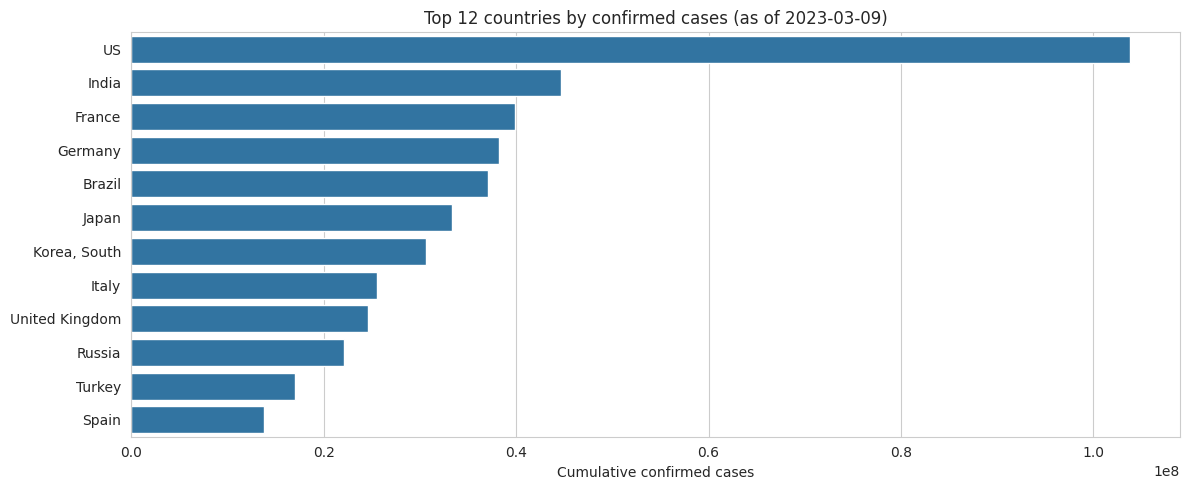

In [20]:
# Latest cumulative by country (top 12)
latest_date = conf_long['Date'].max()
latest = conf_long[conf_long['Date']==latest_date].sort_values('Confirmed', ascending=False)
top12 = latest.head(12)

plt.figure(figsize=(12,5))
sns.barplot(data=top12, x='Confirmed', y='Country/Region', orient='h')
plt.title(f"Top 12 countries by confirmed cases (as of {latest_date.date()})")
plt.xlabel("Cumulative confirmed cases")
plt.ylabel("")
plt.tight_layout()
plt.show()


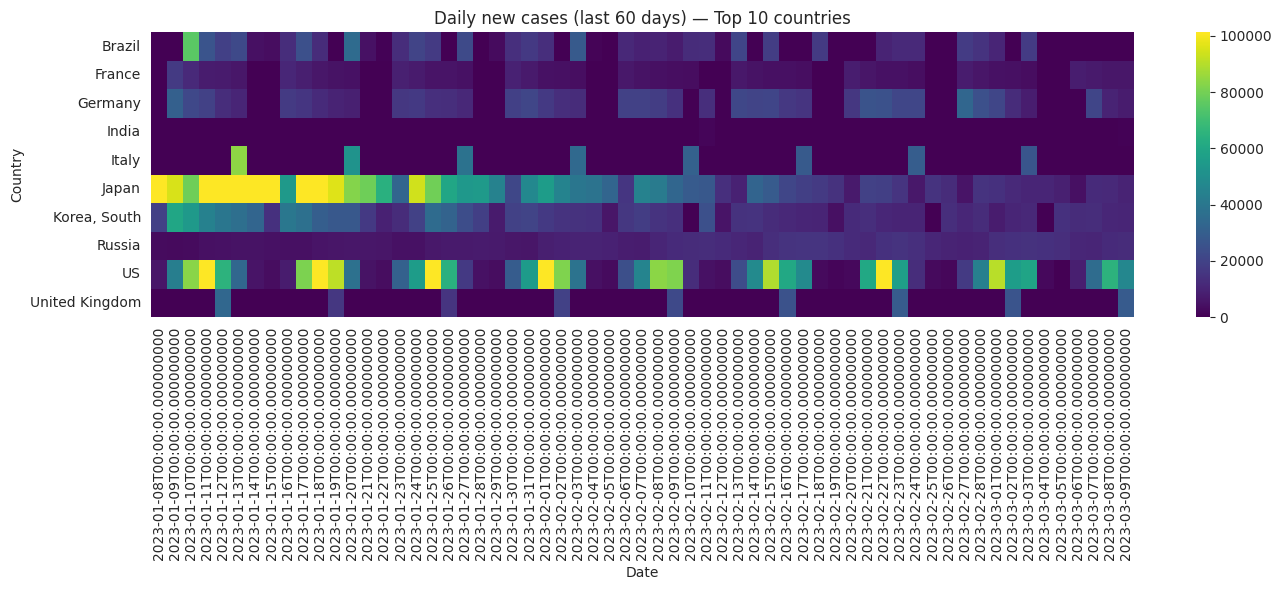

In [21]:
# Heatmap for recent daily new cases for top 10 countries
top10_countries = top12['Country/Region'].head(10).tolist()
last60 = conf_long[conf_long['Date'] >= (latest_date - pd.Timedelta(days=60))]
heat = last60[last60['Country/Region'].isin(top10_countries)]\
         .pivot(index='Country/Region', columns='Date', values='New_Cases')\
         .fillna(0)

plt.figure(figsize=(14,6))
sns.heatmap(heat, cmap="viridis", robust=True)
plt.title("Daily new cases (last 60 days) — Top 10 countries")
plt.xlabel("Date")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [22]:
# compute CFR (Deaths / Confirmed) using the deaths_long data
# Merge latest confirmed and deaths
latest_conf = conf_long[conf_long['Date']==latest_date][['Country/Region','Confirmed']]
latest_deaths = deaths_long[deaths_long['Date']==latest_date][['Country/Region','Deaths']]

latest_merge = latest_conf.merge(latest_deaths, on='Country/Region', how='left').fillna(0)
latest_merge['CFR_percent'] = 100 * latest_merge['Deaths'] / latest_merge['Confirmed'].replace(0, np.nan)
latest_merge = latest_merge.replace([np.inf, -np.inf], np.nan).fillna(0)
top_cfr = latest_merge.sort_values('CFR_percent', ascending=False).head(10)

top_cfr[['Country/Region','Confirmed','Deaths','CFR_percent']]


,Country/Region,Confirmed,Deaths,CFR_percent
93,"Korea, North",1,6,600.000000
107,MS Zaandam,9,2,22.222222
198,Yemen,11945,2159,18.074508
169,Sudan,63829,5017,7.860064
174,Syria,57467,3164,5.505769
164,Somalia,27324,1361,4.980969
141,Peru,4487553,219539,4.892176
54,Egypt,515759,24812,4.810774
117,Mexico,7483444,333188,4.452335
22,Bosnia and Herzegovina,401729,16280,4.052483


In [23]:
# 7-day growth rate for each country
def perf_growth_rate(df_country, days=7):
    df_country = df_country.sort_values('Date')
    if len(df_country) < days+1:
        return np.nan

    # percent change in cumulative confirmed from (t-days) to t
    a = df_country['Confirmed'].iloc[-days-1]
    b = df_country['Confirmed'].iloc[-1]
    if a == 0:
        return np.nan
    return (b - a)/a * 100

countries = conf_long['Country/Region'].unique()
growth_list = []
for c in countries:
    s = conf_long[conf_long['Country/Region']==c]
    gr = perf_growth_rate(s, days=7)
    growth_list.append((c, gr))

growth_df = pd.DataFrame(growth_list, columns=['Country/Region','7d_growth_pct'])
growth_df = growth_df.sort_values('7d_growth_pct', ascending=False).head(15)
growth_df


,Country/Region,7d_growth_pct
119,Moldova,0.607457
10,Austria,0.590518
129,New Zealand,0.514775
42,Costa Rica,0.461814
147,Russia,0.399070
36,Chile,0.390480
13,Bahrain,0.371719
25,Brunei,0.345535
182,Trinidad and Tobago,0.328586
117,Mexico,0.316145
